# **Cats vs Dogs Classification**

In [7]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torch import optim
import cv2, glob, numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchsummary import summary

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
!kaggle datasets download -d tongpython/cat-and-dog

Dataset URL: https://www.kaggle.com/datasets/tongpython/cat-and-dog
License(s): CC0-1.0
100% 217M/218M [00:11<00:00, 23.1MB/s]
100% 218M/218M [00:11<00:00, 20.7MB/s]


In [5]:
!unzip cat-and-dog.zip

Streaming output truncated to the last 5000 lines.
  inflating: training_set/training_set/cats/cat.3704.jpg  
  inflating: training_set/training_set/cats/cat.3705.jpg  
  inflating: training_set/training_set/cats/cat.3706.jpg  
  inflating: training_set/training_set/cats/cat.3707.jpg  
  inflating: training_set/training_set/cats/cat.3708.jpg  
  inflating: training_set/training_set/cats/cat.3709.jpg  
  inflating: training_set/training_set/cats/cat.371.jpg  
  inflating: training_set/training_set/cats/cat.3710.jpg  
  inflating: training_set/training_set/cats/cat.3711.jpg  
  inflating: training_set/training_set/cats/cat.3712.jpg  
  inflating: training_set/training_set/cats/cat.3713.jpg  
  inflating: training_set/training_set/cats/cat.3714.jpg  
  inflating: training_set/training_set/cats/cat.3715.jpg  
  inflating: training_set/training_set/cats/cat.3716.jpg  
  inflating: training_set/training_set/cats/cat.3717.jpg  
  inflating: training_set/training_set/cats/cat.3718.jpg  
  infl

**Training and Test Dataset folders**

In [6]:
train_data_dir = '/content/training_set/training_set'
test_data_dir = '/content/test_set/test_set'

**A class that fetch data**

In [12]:
class cats_dogs(Dataset):
  def __init__(self, folder):
    cats = glob.glob(folder+'/cats/*.jpg')
    dogs = glob.glob(folder+'/dogs/*.jpg')
    self.fpaths = cats + dogs
    from random import shuffle, seed;
    seed(10);
    shuffle(self.fpaths)
    self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths] # dog=1 & cat=0

  def __len__(self):
    return len(self.fpaths)

  def __getitem__(self, ix):
    f = self.fpaths[ix]
    target = self.targets[ix]
    im = (cv2.imread(f)[:, :, ::-1])
    im = cv2.resize(im, (224, 224))
    return torch.tensor(im/255).permute(2, 0, 1).to(device).float(), torch.tensor([target]).float().to(device)

In [13]:
data = cats_dogs(train_data_dir)
im, label = data[200]

In [15]:
len(data)

8005

tensor([1.], device='cuda:0')


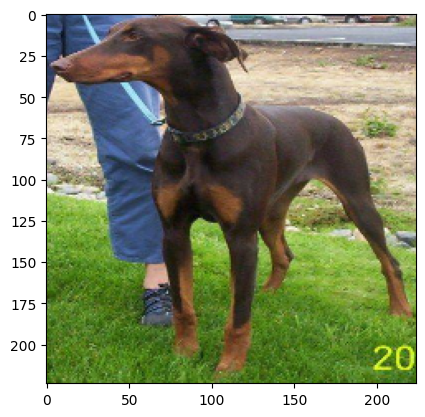

In [18]:
plt.imshow(im.permute(1, 2, 0).cpu())
print(label)

**Model Architecture**

In [25]:
def conv_layer(ni, no, kernel_size, stride=1):
  return nn.Sequential(
      nn.Conv2d(ni, no, kernel_size, stride),
      nn.ReLU(),
      nn.BatchNorm2d(no),
      nn.MaxPool2d(2)
  )

def get_model():
  model = nn.Sequential(
      conv_layer(3, 64, 3),
      conv_layer(64, 512, 3),
      conv_layer(512, 512, 3),
      conv_layer(512, 512, 3),
      conv_layer(512, 512, 3),
      conv_layer(512, 512, 3),
      nn.Flatten(),
      nn.Linear(512, 1),
      nn.Sigmoid()
  ).to(device)

  loss_fn = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  return model, loss_fn, optimizer

**model initialization and summary**

In [32]:
model, loss_fn, optimizer = get_model()
summary(model, input_size=(3, 224, 224));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 222, 222]           1,792
              ReLU-2         [-1, 64, 222, 222]               0
       BatchNorm2d-3         [-1, 64, 222, 222]             128
         MaxPool2d-4         [-1, 64, 111, 111]               0
            Conv2d-5        [-1, 512, 109, 109]         295,424
              ReLU-6        [-1, 512, 109, 109]               0
       BatchNorm2d-7        [-1, 512, 109, 109]           1,024
         MaxPool2d-8          [-1, 512, 54, 54]               0
            Conv2d-9          [-1, 512, 52, 52]       2,359,808
             ReLU-10          [-1, 512, 52, 52]               0
      BatchNorm2d-11          [-1, 512, 52, 52]           1,024
        MaxPool2d-12          [-1, 512, 26, 26]               0
           Conv2d-13          [-1, 512, 24, 24]       2,359,808
             ReLU-14          [-1, 512,

In [33]:
def get_data():
    train = cats_dogs(train_data_dir)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last = True) # ignoring the last batch
    val = cats_dogs(test_data_dir)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
    return trn_dl, val_dl

In [34]:
def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [35]:
@torch.no_grad()
def val_loss(x, y, model):
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [37]:
# Define the model and fetch the required data loader
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

**Train the model over increasing epochs**

In [38]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    for ix, batch in enumerate(iter(trn_dl)):
        #print(ix)
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

    print(f'Training: Epoch {epoch+1} Loss = {train_epoch_loss}, Accuracy = {train_epoch_accuracy}')
    print(f'Validation: Epoch {epoch+1} Loss = {validation_loss}, Accuracy = {val_epoch_accuracy}')

Training: Epoch 1 Loss = 0.6827124687433243, Accuracy = 0.7295
Validation: Epoch 1 Loss = 0.7734641432762146, Accuracy = 0.7251984126984127
Training: Epoch 2 Loss = 0.5364874304533005, Accuracy = 0.787625
Validation: Epoch 2 Loss = 0.4926060736179352, Accuracy = 0.7867063492063492
Training: Epoch 3 Loss = 0.4292021143436432, Accuracy = 0.857
Validation: Epoch 3 Loss = 0.21820542216300964, Accuracy = 0.8363095238095238
Training: Epoch 4 Loss = 0.32997355961799624, Accuracy = 0.906875
Validation: Epoch 4 Loss = 0.20279642939567566, Accuracy = 0.8864087301587301
Training: Epoch 5 Loss = 0.2509962724745274, Accuracy = 0.9245
Validation: Epoch 5 Loss = 0.25269442796707153, Accuracy = 0.876984126984127


<ipython-input-41-117473b7f774>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


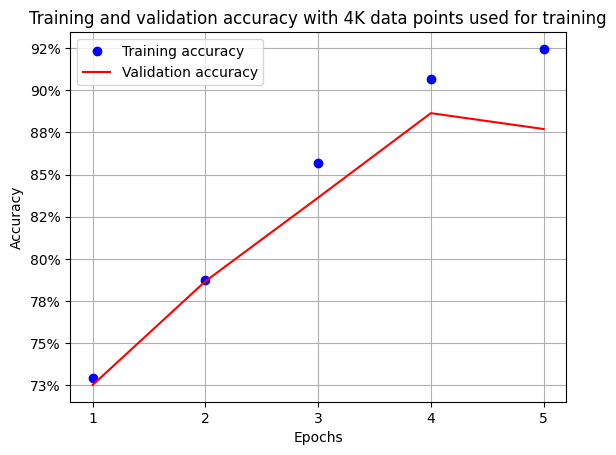

In [41]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with 4K data points used for training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

---



# Impact on the number of images used for traning

## 1k datapoints
**500 datapoints for each class in dataset**

In [42]:
class cats_dogs(Dataset):
  def __init__(self, folder):
    cats = glob.glob(folder+'/cats/*.jpg')
    dogs = glob.glob(folder+'/dogs/*.jpg')
    self.fpaths = cats[:500] + dogs[:500] # take the first 500
    from random import shuffle, seed; seed(10); shuffle(self.fpaths)
    self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths] # dog=1 & cat=0
  def __len__(self):
    return len(self.fpaths)
  def __getitem__(self, ix):
    f = self.fpaths[ix]
    target = self.targets[ix]
    im = (cv2.imread(f)[:,:,::-1])
    im = cv2.resize(im, (224,224))
    return torch.tensor(im/255).permute(2,0,1).to(device).float(), torch.tensor([target]).float().to(device)

In [43]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [44]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies_1k = [], []
for epoch in range(5):
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies_1k.append(val_epoch_accuracy)

    print(f'Training: Epoch {epoch+1} Loss = {train_epoch_loss}, Accuracy = {train_epoch_accuracy}')
    print(f'Validation: Epoch {epoch+1} Loss = {validation_loss}, Accuracy = {val_epoch_accuracy}')

Training: Epoch 1 Loss = 1.142186447497337, Accuracy = 0.6028225806451613
Validation: Epoch 1 Loss = 0.6911295056343079, Accuracy = 0.561491935483871
Training: Epoch 2 Loss = 0.6705034894327964, Accuracy = 0.6058467741935484
Validation: Epoch 2 Loss = 0.691433846950531, Accuracy = 0.5463709677419355
Training: Epoch 3 Loss = 0.6294474197972205, Accuracy = 0.6854838709677419
Validation: Epoch 3 Loss = 0.7175281047821045, Accuracy = 0.5957661290322581
Training: Epoch 4 Loss = 0.6020819064109556, Accuracy = 0.7348790322580645
Validation: Epoch 4 Loss = 0.6408873796463013, Accuracy = 0.6411290322580645
Training: Epoch 5 Loss = 0.5606768717688899, Accuracy = 0.719758064516129
Validation: Epoch 5 Loss = 0.7906638383865356, Accuracy = 0.5997983870967742


<ipython-input-45-5f34a50ac03a>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


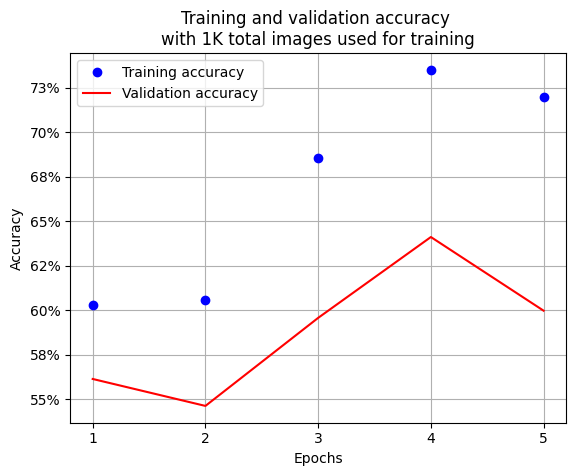

In [45]:
epochs = np.arange(5)+1

plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies_1k, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy \nwith 1K total images used for training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

## 2K datapoints
**1000 datapoints for each classs**

In [46]:
class cats_dogs(Dataset):
  def __init__(self, folder):
    cats = glob.glob(folder+'/cats/*.jpg')
    dogs = glob.glob(folder+'/dogs/*.jpg')
    self.fpaths = cats[:1000] + dogs[:1000]
    from random import shuffle, seed; seed(10); shuffle(self.fpaths)
    self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths] # dog=1 & cat=0
  def __len__(self):
    return len(self.fpaths)
  def __getitem__(self, ix):
    f = self.fpaths[ix]
    target = self.targets[ix]
    im = (cv2.imread(f)[:,:,::-1])
    im = cv2.resize(im, (224,224))
    return torch.tensor(im/255).permute(2,0,1).to(device).float(), torch.tensor([target]).float().to(device)

In [47]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [48]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies_2k = [], []
for epoch in range(5):
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    for ix, batch in enumerate(iter(trn_dl)):
        #print(ix)
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies_2k.append(val_epoch_accuracy)

    print(f'Training: Epoch {epoch+1} Loss = {train_epoch_loss}, Accuracy = {train_epoch_accuracy}')
    print(f'Validation: Epoch {epoch+1} Loss = {validation_loss}, Accuracy = {val_epoch_accuracy}')

Training: Epoch 1 Loss = 0.7330426006547867, Accuracy = 0.6300403225806451
Validation: Epoch 1 Loss = 0.6672034859657288, Accuracy = 0.5962701612903226
Training: Epoch 2 Loss = 0.6340028273482476, Accuracy = 0.6900201612903226
Validation: Epoch 2 Loss = 0.6949657201766968, Accuracy = 0.6431451612903226
Training: Epoch 3 Loss = 0.5749514136583574, Accuracy = 0.6960685483870968
Validation: Epoch 3 Loss = 0.7967381477355957, Accuracy = 0.6456653225806451
Training: Epoch 4 Loss = 0.5846796530869699, Accuracy = 0.7777217741935484
Validation: Epoch 4 Loss = 0.5822881460189819, Accuracy = 0.7142137096774194
Training: Epoch 5 Loss = 0.48432054731153673, Accuracy = 0.796875
Validation: Epoch 5 Loss = 0.4981181025505066, Accuracy = 0.7001008064516129


<ipython-input-49-0cfe51c3cd99>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


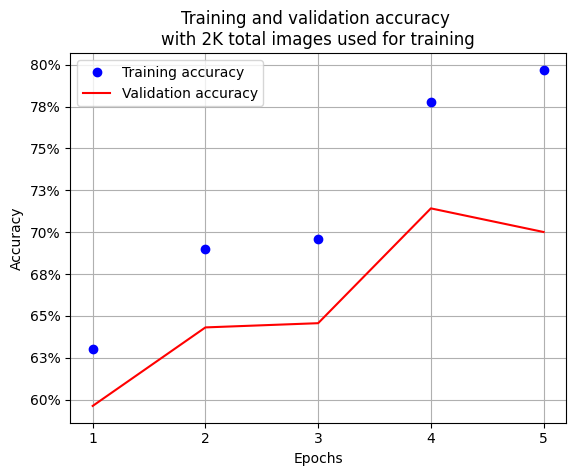

In [49]:
epochs = np.arange(5)+1
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies_2k, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy \nwith 2K total images used for training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

## 4K datapoints
**2000 datapoints per class**

In [50]:
class cats_dogs(Dataset):
  def __init__(self, folder):
    cats = glob.glob(folder+'/cats/*.jpg')
    dogs = glob.glob(folder+'/dogs/*.jpg')
    self.fpaths = cats[:2000] + dogs[:2000]
    from random import shuffle, seed; seed(10); shuffle(self.fpaths)
    self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths] # dog=1 & cat=0
  def __len__(self): return len(self.fpaths)
  def __getitem__(self, ix):
    f = self.fpaths[ix]
    target = self.targets[ix]
    im = (cv2.imread(f)[:,:,::-1])
    im = cv2.resize(im, (224,224))
    return torch.tensor(im/255).permute(2,0,1).to(device).float(), torch.tensor([target]).float().to(device)

In [51]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [52]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies_4k = [], []
for epoch in range(5):
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    for ix, batch in enumerate(iter(trn_dl)):
        #print(ix)
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies_4k.append(val_epoch_accuracy)

    print(f'Training: Epoch {epoch+1} Loss = {train_epoch_loss}, Accuracy = {train_epoch_accuracy}')
    print(f'Validation: Epoch {epoch+1} Loss = {validation_loss}, Accuracy = {val_epoch_accuracy}')

Training: Epoch 1 Loss = 0.7421607546806336, Accuracy = 0.68775
Validation: Epoch 1 Loss = 0.5421478748321533, Accuracy = 0.6527777777777778
Training: Epoch 2 Loss = 0.5724719574451447, Accuracy = 0.767
Validation: Epoch 2 Loss = 0.4010809659957886, Accuracy = 0.7366071428571429
Training: Epoch 3 Loss = 0.5028860924243927, Accuracy = 0.7775
Validation: Epoch 3 Loss = 0.6151188611984253, Accuracy = 0.7490079365079365
Training: Epoch 4 Loss = 0.4245268052816391, Accuracy = 0.85925
Validation: Epoch 4 Loss = 0.46322765946388245, Accuracy = 0.8095238095238095
Training: Epoch 5 Loss = 0.3454663898348808, Accuracy = 0.885
Validation: Epoch 5 Loss = 0.3996042013168335, Accuracy = 0.8273809523809523


<ipython-input-53-d98b43977f63>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


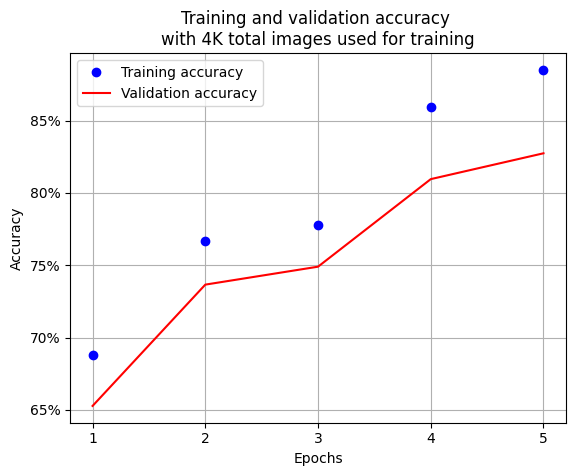

In [53]:
epochs = np.arange(5)+1

plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies_4k, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy \nwith 4K total images used for training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

---

**Plotting training and validation accuracy together, which is trained with different number of datapoints**


<ipython-input-54-af8a3333f4d9>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


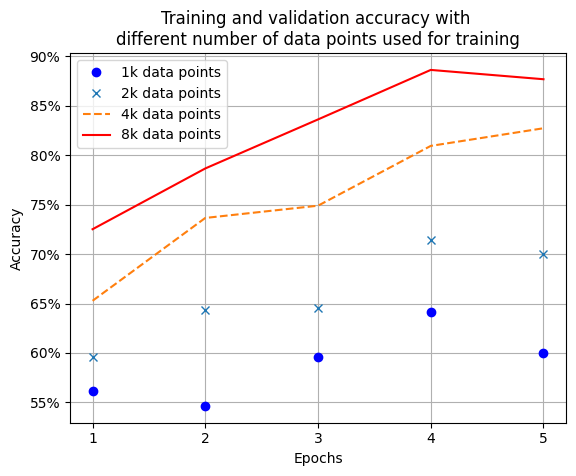

In [54]:
plt.plot(epochs, val_accuracies_1k, 'bo', label='1k data points')
plt.plot(epochs, val_accuracies_2k, 'x', label='2k data points')
plt.plot(epochs, val_accuracies_4k, '--', label='4k data points',markersize = 20)
plt.plot(epochs, val_accuracies, 'r', label='8k data points')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with \ndifferent number of data points used for training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()